In [2]:
import requests
import json
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from os import listdir
import plotly.express as px
import secret


In [2]:
makes = [
    "acura",
    # "buick",
    # "cadillac",
    # "chevrolet",
    # "chrysler",
    # "gmc",
    # "ford",
    # "honda",
    # "infiniti",
    # "jeep",
    # "kia",
    # "mitsubishi",
    # "nissan",
    # "porsche",
    # "ram",
    # "subaru",
    # "toyota",
    # "volkswagen",
    # "volvo",
    # "alfa_romeo",
    # "rolls_royce",
    # "mini",
    # "fiat",
    # "aston_martin",
    # "maserati",
    # "bmw",
    # "mercedes_benz"
]


### Pulling down from new API

In [44]:
def pull_down_weekly_listings() -> pd.DataFrame:
    
    url = secret.API_URL
    payload = ""
    headers = {"x-api-key": secret.API_KEY}
    
    
    
    df = pd.DataFrame()
    results = []
    
    
    for i in range(7):
        
        day = (datetime.now() - timedelta(days=i)).date().isoformat()
        
        for make in makes:
    
            querystring = {"make":make,"date":day}


            response = requests.request("GET", url, data=payload, headers=headers, params=querystring)

            df_temp = pd.read_json(response.text)
            
            df = pd.concat([df, df_temp])
            
            

    df['Date'] = pd.to_datetime(df['Date'])
    df['Year'] = df['Year'].astype(str)
    
    return df
        
        
        
        
    
    
    
df = pull_down_weekly_listings()  
df.info()  

<class 'pandas.core.frame.DataFrame'>
Int64Index: 195 entries, 0 to 25
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Rating Count  195 non-null    int64         
 1   Date          195 non-null    datetime64[ns]
 2   Year          195 non-null    object        
 3   Mileage       195 non-null    int64         
 4   Price         195 non-null    int64         
 5   Dealer Name   195 non-null    object        
 6   ID            195 non-null    object        
 7   Make          195 non-null    object        
 8   Rating        195 non-null    float64       
 9   Date-Make     195 non-null    object        
 10  Name          195 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 18.3+ KB


In [41]:
df['Date'].value_counts().sort_index()

2022-08-16    26
2022-08-17    34
2022-08-18    34
2022-08-19    32
2022-08-20     7
2022-08-21    35
2022-08-22    27
Name: Date, dtype: int64

In [16]:
df['Year'].dt.year

0     1970
1     1970
2     1970
3     1970
4     1970
      ... 
21    1970
22    1970
23    1970
24    1970
25    1970
Name: Year, Length: 195, dtype: int64

In [42]:
df['Name'].value_counts()

2020 Acura MDX 3.5L w/Technology Package              20
2020 Acura RDX Technology Package                     15
2020 Acura MDX 3.5L                                   14
2019 Acura MDX 3.5L w/Technology Package              12
2020 Acura TLX FWD                                    11
2020 Acura RDX Base                                   10
2019 Acura RDX Technology Package                     10
2021 Acura RDX Technology Package                      9
2019 Acura MDX 3.5L                                    8
2019 Acura RDX Base                                    7
2020 Acura RDX A-Spec                                  7
2020 Acura TLX V6 w/Technology Package                 6
2020 Acura RDX Advance Package                         6
2021 Acura TLX Technology                              5
2022 Acura MDX A-Spec                                  5
2022 Acura MDX Type S                                  3
2018 Acura MDX 3.5L w/Technology Package               3
2019 Acura RDX Base (A10)      

## Viz #1 : Scatterplot of Year vs Price, then when you hover over it, you can see what kind of listing it is

<AxesSubplot:xlabel='Mileage', ylabel='Price'>

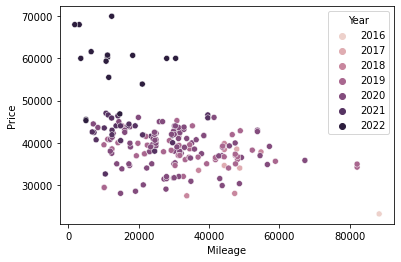

In [43]:
sns.scatterplot(data = df, x = 'Mileage', y = 'Price', hue = 'Year')

### Replicating it in plotly

In [26]:
fig = px.scatter(df.sort_values(by='Year'), x = "Mileage", y = "Price", color = "Year", hover_data=["Name"])
fig.show()

### Viz #2: Interactive Table With Sorting Functionality

In [37]:
unwanted_columns = ['Date-Make', 'Dealer Name', 'ID', 'Rating Count', 'Date', 'Rating']

columns = list(df.columns)
columns = [i for i in columns if i not in unwanted_columns]
# columns.remove('Date-Make')
# columns.remove('Dealer Name')
columns

['Year', 'Mileage', 'Price', 'Make', 'Name']

In [41]:
import plotly.graph_objects as go

columns = ['Name', 'Year', 'Price', 'Mileage']

fig = go.Figure(data = [go.Table(
    header = dict(values=columns,
            fill_color='paleturquoise',
            align = 'left'),
    cells = dict(values = [df.Name, df.Year, df.Price, df.Mileage],
                 fill_color = 'lavender',
                 align = 'left'))

])

fig.show()

#### Possible Viz's

- Listings of each car make and their price in the past week

- Select one car make-model from a drop-down menu and check how the average price listing has been, avg with # listings - recent week
- mileage to price correlation for each make - recent week 
- donut chart for each different model



- Make some linear regression with car models, price